In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
import seaborn as sns
from src.utils import load_data
sns.set_style('darkgrid')
sns.set(font_scale=.8)

In [26]:
# Load reviews as dataframe
reviews = load_data('../raw/reviews.feather', 100000)

Data loaded from ../raw/reviews.feather


## BeerAdvocate Reviews
- Data Cleaning
- #samples
- #features
- univariate analysis
- further analysis

## Exploratory Data Analysis

In [27]:
# Util Function
def display_chart(df, title='', xlabel='', ylabel=''):
    plt.rc('axes', axisbelow=True)
    plt.figure(figsize=(10, 6))
    plt.hist(df, bins=20, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


## Data Cleaning

First, identify all columns that have missing values, i.e., nan values within number ratings.
For that, convert the properties of those data entries into numeric value and fill their value
up with the overall rating value.

In [28]:
# Data Cleaning

# All columns
print(list(reviews.columns))


# Identify missing data in columns
missing_reviews = reviews.isna().sum()

# ratings in float
reviews['appearance'] = pd.to_numeric(reviews['appearance'], errors='coerce', downcast='float')
reviews['aroma'] = pd.to_numeric(reviews['aroma'], errors='coerce', downcast='float')
reviews['palate'] = pd.to_numeric(reviews['palate'], errors='coerce', downcast='float')
reviews['taste'] = pd.to_numeric(reviews['taste'], errors='coerce', downcast='float')
reviews['overall'] = pd.to_numeric(reviews['overall'], errors='coerce', downcast='float')

# for missing ratings in categories, use the overall rating to not loose the data entry
reviews['appearance'] = reviews['appearance'].fillna(reviews['rating'])
reviews['aroma'] = reviews['aroma'].fillna(reviews['rating'])
reviews['palate'] = reviews['palate'].fillna(reviews['rating'])
reviews['taste'] = reviews['taste'].fillna(reviews['rating'])
reviews['overall'] = reviews['overall'].fillna(reviews['rating'])


print("Columns with missing values:")
print(missing_reviews[missing_reviews > 0])

['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating', 'text']
Columns with missing values:
Series([], dtype: int64)


We want to avoid short reviews that have no interesting content judging by the length of the rating.

In [29]:
# Discard reviews under 100 characters
reviews = reviews[reviews['text'].str.len() > 100]

## General Beer-Review Stats

Display data dimensionality, feature names and feature types.

In [30]:
reviews['appearance'] = reviews['appearance'].astype('float32')
reviews['aroma'] = reviews['aroma'].astype('float32')
reviews['palate'] = reviews['palate'].astype('float32')
reviews['taste'] = reviews['taste'].astype('float32')
reviews['overall'] = reviews['overall'].astype('float32')
reviews['rating'] = reviews['rating'].astype('float32')


print(reviews.shape)
print()
print(reviews.columns)
print()
print(reviews.info())
print()
print(reviews['rating'].describe())

(99999, 16)
Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'text'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   beer_name     99999 non-null  object        
 1   beer_id       99999 non-null  object        
 2   brewery_name  99999 non-null  object        
 3   brewery_id    99999 non-null  object        
 4   style         99999 non-null  object        
 5   abv           99999 non-null  object        
 6   date          99999 non-null  datetime64[ns]
 7   user_name     99999 non-null  object        
 8   user_id       99999 non-null  object        
 9   appearance    99999 non-null  float32       
 10  aroma         99999 non-null  float32       
 11  palate 

Display descriptive data for each beer.

In [31]:
rating_columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

reviews.groupby('beer_name')[rating_columns].describe(percentiles=[])

appearance                            \
                                        count      mean       std   min   
beer_name                                                                 
"Check-Mate" Cask Pilsner                 1.0  3.500000       NaN  3.50   
"Little John's Myth" Robust Porter        1.0  4.000000       NaN  4.00   
"Stout Stoat" Stout                       4.0  4.375000  0.478714  4.00   
#MashTag 2013                             9.0  3.722222  0.317324  3.00   
#MashTag 2014                             4.0  3.937500  0.314576  3.50   
...                                       ...       ...       ...   ...   
Zăganu Brună                              2.0  3.375000  0.883883  2.75   
Zăganu India Pale Ale                     1.0  3.500000       NaN  3.50   
Zăganu Roșie                              1.0  3.500000       NaN  3.50   
Æther Blæc                                1.0  3.500000       NaN  3.50   
Òrach Slie                               11.0  3.590909  0.301511  3.00   

                                                aroma                      \
                                      50%   max count      mean       std   
beer_name                                                                   
"Check-Mate" Cask Pilsner           3.500  3.50   1.0  3.500000       NaN   
"Little John's Myth" Robust Porter  4.000  4.00   1.0  4.000000       NaN   
"Stout Stoat" Stout                 4.250  5.00   4.0  3.750000  0.288675   
#MashTag 2013                       3.750  4.00   9.0  3.694444  0.300463   
#MashTag 2014                       4.000  4.25   4.0  4.000000  0.000000   
...                                   ...   ...   ...       ...       ...   
Zăganu Brună                        3.375  4.00   2.0  3.250000  0.353553   
Zăganu India Pale Ale               3.500  3.50   1.0  3.500000       NaN   
Zăganu Roșie                        3.500  3.50   1.0  3.500000       NaN   
Æther Blæc                          3.500  3.50   1.0  4.000000       NaN   
Òrach Slie                          3.500  4.00  11.0  3.750000  0.335410   

                                          ...   overall                    \
                                     min  ...       std   min   50%   max   
beer_name                                 ...                               
"Check-Mate" Cask Pilsner           3.50  ...       NaN  3.50  3.50  3.50   
"Little John's Myth" Robust Porter  4.00  ...       NaN  4.50  4.50  4.50   
"Stout Stoat" Stout                 3.50  ...  0.250000  4.00  4.00  4.50   
#MashTag 2013                       3.00  ...  0.195434  3.50  3.75  4.00   
#MashTag 2014                       4.00  ...  0.250000  4.00  4.00  4.50   
...                                  ...  ...       ...   ...   ...   ...   
Zăganu Brună                        3.00  ...  0.353553  3.25  3.50  3.75   
Zăganu India Pale Ale               3.50  ...       NaN  3.50  3.50  3.50   
Zăganu Roșie                        3.50  ...       NaN  3.50  3.50  3.50   
Æther Blæc                          4.00  ...       NaN  3.00  3.00  3.00   
Òrach Slie                          3.25  ...  0.269680  3.50  3.75  4.25   

                                   rating                                   \
                                    count      mean       std   min    50%   
beer_name                                                                    
"Check-Mate" Cask Pilsner             1.0  3.500000       NaN  3.50  3.500   
"Little John's Myth" Robust Porter    1.0  4.300000       NaN  4.30  4.300   
"Stout Stoat" Stout                   4.0  4.112500  0.292275  3.88  4.015   
#MashTag 2013                         9.0  3.676667  0.178746  3.49  3.570   
#MashTag 2014                         4.0  4.060000  0.140712  3.97  4.000   
...                                   ...       ...       ...   ...    ...   
Zăganu Brună                          2.0  3.500000  0.296985  3.29  3.500   
Zăganu India Pale Ale                 1.0  3.5

Display histogram and boxplot for rating column.

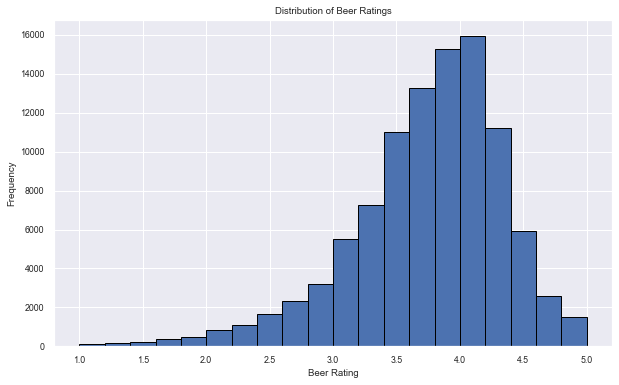

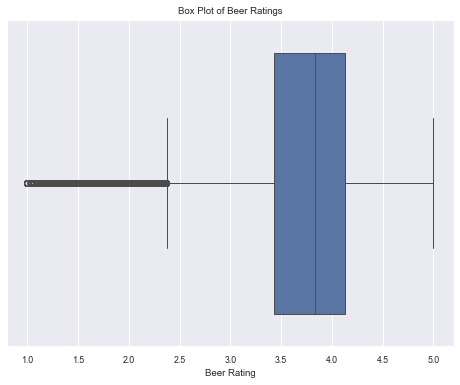

In [32]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist(reviews['rating'], bins=20, edgecolor='black')
plt.title('Distribution of Beer Ratings')
plt.xlabel('Beer Rating')
plt.ylabel('Frequency')
plt.show()

# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=reviews['rating'])
plt.title('Box Plot of Beer Ratings')
plt.xlabel('Beer Rating')
plt.show()


In order to be able to properly analyse the textual reviews for each beer, we
set a threshold of at least 50 reviews that need to be submitted for one beer.

In [33]:
# Number of involved beer with review

# Get number of reviews for each beer
beer_type_counts = reviews['beer_id'].value_counts()
print(beer_type_counts)

# Filter beers with more than 50 ratings
beer_reviews_over_50 = reviews[reviews.groupby('beer_id').count() > 50]

'''
# Show histogram
plt.figure(figsize=(12, 6))
beer_type_counts.plot(kind='bar', edgecolor='blue')
plt.title('Frequency of Each Beer Type')
plt.xlabel('Beer Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()
'''

73        2360
571       2290
782       1766
576       1475
219       1362
          ... 
193070       1
39752        1
84828        1
252773       1
139363       1
Name: beer_id, Length: 8459, dtype: int64


"\n# Show histogram\nplt.figure(figsize=(12, 6))\nbeer_type_counts.plot(kind='bar', edgecolor='blue')\nplt.title('Frequency of Each Beer Type')\nplt.xlabel('Beer Type')\nplt.ylabel('Frequency')\nplt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility\nplt.tight_layout()\nplt.show()\n"

## Univariate Analysis

We look at the distribution of all quantitive rating features as well as the overall rating
feature of all reviews.

<AxesSubplot:xlabel='appearance', ylabel='Density'>

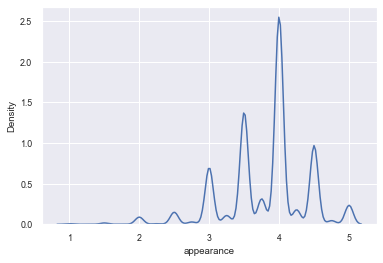

In [45]:
sns.histplot(x='appearance', data=reviews)

<AxesSubplot:xlabel='aroma', ylabel='Count'>

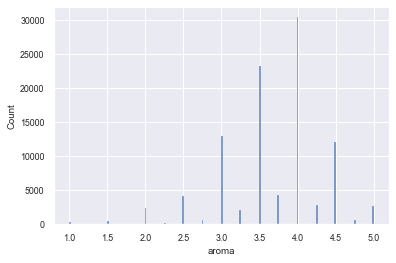

In [35]:
sns.histplot(x='aroma', data=reviews)

<AxesSubplot:xlabel='palate', ylabel='Count'>

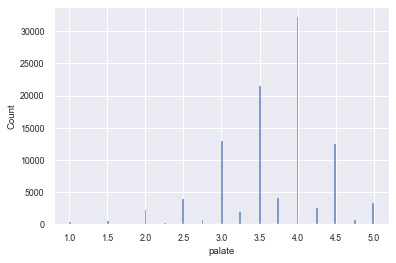

In [36]:
sns.histplot(x='palate', data=reviews)

<AxesSubplot:xlabel='taste', ylabel='Count'>

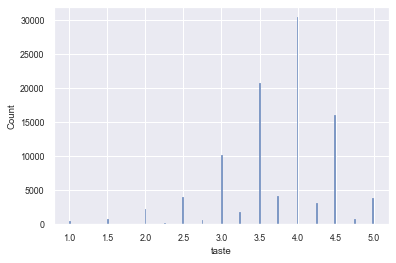

In [37]:
sns.histplot(x='taste', data=reviews)

<AxesSubplot:xlabel='overall', ylabel='Count'>

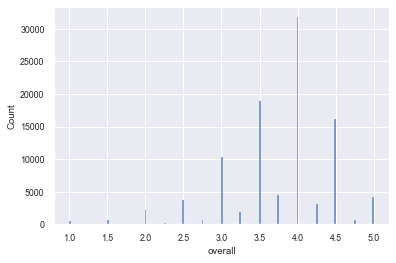

In [38]:
sns.histplot(x='overall', data=reviews)

<AxesSubplot:xlabel='rating', ylabel='Count'>

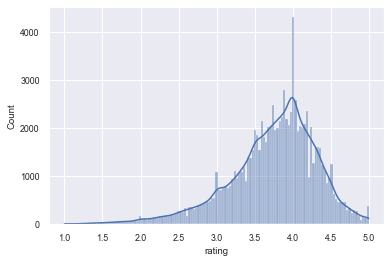

In [49]:
# Histogram
sns.histplot(x='rating', data=reviews, kde=True)


## Further Analysis

We look at the distribution of the average rating per beer considering only the final overall
rating.

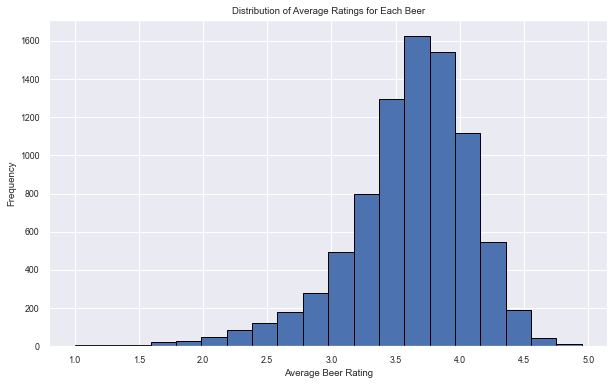

In [44]:
# Distribution of average rating per beer (final rating)
average_rating_beer = reviews.groupby('beer_id')['rating'].mean()

# Display it in a histogram
display_chart(average_rating_beer, 'Distribution of Average Ratings for Each Beer',
              'Average Beer Rating', 'Frequency')

We calculate the number of reviews that each user submitted within the dataset and filter after
those that have explictely have more than 10 reviews. If within those ten reviews the average
final rating is lower than 2, we would eventually discard those users.

                     count
user_id                   
blackhaddock.90923    1569
wl0307.16869          1528
emperorbevis.621888   1336
jazzyjeff13.522501    1041
stjamesgate.163714     734
flyingpig.524986       637
vinicole.65585         628
cwrwambyth.557249      441
mdagnew.19527          434
bark.4217              366
ciocanelu.691982       346
charlatan.14050        327
biboergosum.168458     315
chinchill.199175       297
rastaman.264           275
metter98.95017         267
sammy.3853             266
crazydavros.212765     261
dj-hophead.992772      261
cypressbob.3708        261


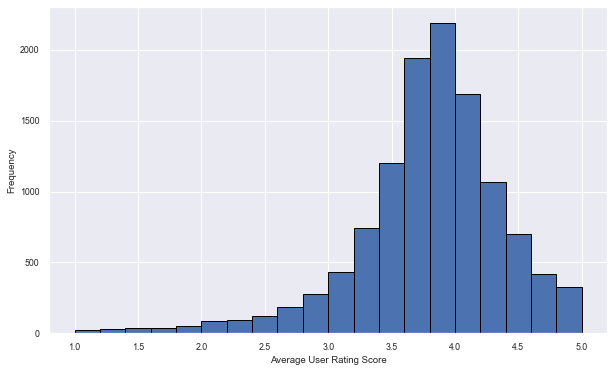

In [41]:
# Distribution of average rating per user for any review

# number of reviews per user
user_ratings_count = (
    reviews.groupby('user_id')[['rating']]
    .count()
    .rename(columns={'rating': 'count'})
    .sort_values('count', ascending=False)
    )
print(user_ratings_count.iloc[:20])
user_ratings_count['count'] = pd.to_numeric(user_ratings_count['count'])
user_ratings_count_over_10 = user_ratings_count[user_ratings_count['count'] > 10]

# average rating per user
average_rating_user = (reviews
                       .groupby('user_id')['rating']
                       .mean()
                       .reset_index()
                       )
display_chart(average_rating_user.set_index('user_id'), xlabel='Average User Rating Score', ylabel='Frequency')
# Filter after users that have a user rating under 2 and more than 10 reviews
user_rating_below_2 = average_rating_user[average_rating_user['rating'] < 2]['user_id']
# Drop those users that have an average rating score under 2 and more than 10 reviews
reviews = reviews[~reviews['user_id'].isin(user_rating_below_2) &
                  ~reviews['user_id'].isin(user_ratings_count_over_10)]

We want to measure the offset between each user rating for a specific and the corresponding rating
of the given beer. Then we want to identify those specific reviews that have an offset larger
than three where the corresponding text_review would be interesting to know.

In [42]:
# How far is each user_review rating from the average rating of the given beer
reviews_average_beer_rating = reviews.merge(average_rating_beer, how='left', on=['beer_id'])
reviews_average_beer_rating['rating_diff'] = abs(reviews_average_beer_rating['rating_x'] - reviews_average_beer_rating['rating_y'])

# Filter after those that have a difference of more than 3
reviews_average_beer_rating = reviews_average_beer_rating[reviews_average_beer_rating.rating_diff > 3.5]
reviews_average_beer_rating['rating_diff']


Series([], Name: rating_diff, dtype: float32)